# Capstone Project Baseline

### Imports

In [1]:
# Necessary Imports
import pandas as pd
import numpy as np
import os

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Web Scrapping 
import pandas as pd
import requests
import utils
from bs4 import BeautifulSoup

# Regular Expressions
import re

#Dataset Split 
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#Metric Evaluations
from sklearn.model_selection import cross_val_score

# To enconde the categorials variables
# This module has to be installed into the enviroment being used
import category_encoders as ce

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score

#Pipelines
from sklearn.preprocessing import Imputer, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Heroku
import json
import pickle
import joblib
from flask import Flask, request, jsonify

### Generic Functions

In [2]:
#Model Development
def read_data() -> pd.DataFrame:
    """Imports a dataset containing history of cars searched for contraband. 
                                    
    Returns
        data (pd.DataFrame): Represents the entire dataset, but it ensures that column names are lower case and that are no
                                 whitespaces in between the names
                             The dataframe holds values for:
                                Operation Details and Results (location of the intervention for example) for each car,
                                and the Background of a driver.
                  
    """
    path = os.path.join('data', 'train.csv')
    data = pd.read_csv(path, parse_dates=True)
    
    #Check with Caetano if this is necessary
    for name in data.columns:
        
        data = data.rename(columns={name:name.lower().replace(" ", "_")})
        
    return data

In [3]:
# Model Develpoment
def dropping_variables(df) -> pd.DataFrame:
    """ This function returns a dataframe. Each that has a higher amount than 60% of missing values
    is going to be dropped
    """
    data = df.copy()
    
    variables_to_drop = []
    
    for col in data.columns:
    
        null_count = data[col].isnull().sum()
        
        if null_count > 0.6*len(data):
            variables_to_drop.append(col)
            
    if variables_to_drop == []:
        return data
    else:
        return data.drop([variables_to_drop],axis=1)   

In [4]:
# Model Pre-Proccesing
def replacing_missing_values(df) -> pd.DataFrame:
    """
    """
    data = df.copy()
    
    cols_with_missing_values = []
    col_names = data.columns.tolist()
    
    for col in col_names:
        if data[col].isnull().sum() == 0:
            pass
        else:
            cols_with_missing_values.append(col)
            
    for col in cols_with_missing_values:
        if data[col].dtype.name == 'object':
            data[col] = data[col].fillna(data[col].mode()[0])
        elif data[col].dtype.name == bool:
            data[col] = data[col].fillna(data[col].mode()[0])
        else:
            data[col] = data[col].fillna(data[col].median())
            
    return data

In [5]:
# Model Pre-Processing 
def lower_strip_case_dtype_object(df) -> pd.DataFrame:
    """ Returns a DataFrame in which all the object type variables have been converted to lower case 
    and the whitespaces on the edges have been removed.
    
    Args:
        df(pd.DataFrame): Original DataFrame 
        
    Returns:
        data(pd.DataFrame): Lower and Strip case DataFrame
    """
    data = df.copy()
    
    object_data = data.select_dtypes(include='object')
    object_data_columns = object_data.columns
    
    for col in object_data_columns:
        data[col] = data[col].str.lower().str.strip()
    
    return data

### Functions

In [6]:
def interventionlocation_validation_list():
    """
    """
# Towns and Cities in Connecticut
    towns_cities_url = 'https://portal.ct.gov/Government/Cities-and-Towns'
    
    response_1 = requests.get(towns_cities_url)
    
    
    # Printing short output, if you want to see everything, delete the friendly_print function call
    soup_1 = BeautifulSoup(response_1.content, 'html.parser')
    
    towns_and_cities_info = str(soup_1.findAll('a','title', class_=False))
    
    pattern_1 = r'"\b[A-z][a-z]*\b \b[A-z][a-z]*\b"|"\b[A-z][a-z]*\b"'
    
    connecticut_towns_and_cities =\
    [n.strip('"') for n in re.findall(pattern_1, towns_and_cities_info)\
     if (n != '"noopener noreferrer"')& (n != '"_blank"')&(len(n)>3)][1:-1]
    
#census-designated places in Connecticut
    cdp_connecticut_url = 'https://en.wikipedia.org/wiki/List_of_census-designated_places_in_Connecticut'
    
    response_2 = requests.get(cdp_connecticut_url)
    
    # Printing short output, if you want to see everything, delete the friendly_print function call
    soup_2 = BeautifulSoup(response_2.content, 'html.parser')
    
    cdp_connecticut = str(soup_2.findAll('a','title', class_=False))
    
    pattern_2 = r'[title]{5}=(.*?,)'
    
    removing_special_characters = [re.sub('[",]', '', n) for n in re.findall(pattern_2, cdp_connecticut)[3:-85]]

    removing_county = [re.sub('[County]{6}', '', n) for n in removing_special_characters]

    removing_cdp_village =  np.unique([n.split('(')[0].strip() for n in removing_county]).tolist()

# Villages in connecticut 

    villages_connecticut_url = 'https://en.wikipedia.org/wiki/Category:Villages_in_Connecticut'

    response_3 = requests.get(villages_connecticut_url)

    # Printing short output, if you want to see everything, delete the friendly_print function call
    soup_3= BeautifulSoup(response_3.content, 'html.parser')

    villages_connecticut = str(soup_3.findAll('a','title', class_=False))
    
    pattern_2 = r'[title]{5}=(.*?,)'
    
    villages_list = [re.sub('[",]', '', n) for n in re.findall(pattern_2, cdp_connecticut)[5:-37]]
    
    location_1_word = []
    location_2_word = []
    location_3_word = []
    locations_more_than_3 = []
    
    for n in villages_list:
        if len(n.split()) == 1:
            location_1_word.append(n)
        elif len(n.split()) == 2:
            location_2_word.append(n)
        elif len(n.split()) == 3:
            location_3_word.append(n)
        elif len(n.split()) > 3:
            locations_more_than_3.append(n)
    
    location_2_word = [re.sub('[(CDP)]{5}', '', n) for n in location_2_word]
    
    locations_more_than_3_with_district = [x.split('District')[0]+'District'\
                                       for x in locations_more_than_3 if re.search('District', x)] 
    locations_more_than_3_no_district = [x.split('District')[0]+'District'\
                                       for x in locations_more_than_3 if not re.search('District', x)]
    locations_more_than_3_clean = \
    locations_more_than_3_with_district + [locations_more_than_3_no_district[0].split('>')[0]] +\
    [' '.join(locations_more_than_3_no_district[1].split()[:2])]
    
    villages_final_list = location_1_word+location_2_word+location_3_word+locations_more_than_3_clean
    
# Final list Output

    final_list = np.unique(connecticut_towns_and_cities + removing_cdp_village + villages_final_list).tolist()
    
    final_list = [n.lower() for n in final_list]
    
    return final_list

In [7]:
# In connecticut there are:
## 95 Distinct Police Departments
## 15 CST troops
## 11 Special Jurisdiction Police

def cleaning_department_name(df) -> pd.DataFrame:
    """ Returns a DataFrame with the variable department name corrected
    
    Args:
        df(pd.DataFrame): represents a dataframe where the variable department_name
                          as not been fixed yet
    Returns:
        data(pd.DataFrame): DataFrame with the variable department_name corrected
    """
    data = df.copy()
    
    # Converts all strings to lower case
    data['department_name'] = data['department_name'].str.lower()
    
    # Identifies the specific strings that have 3 or more words. Those were the only cases in which it 
    # was identified values with problems
    indexes_to_change = data[data['department_name'].apply(lambda x: len(x.split())) >= 3].index
    
    data.loc[indexes_to_change,'department_name'] = data.loc[indexes_to_change,'department_name']\
    .apply(lambda x: x.replace('police','').strip())
    
    return data

In [8]:
def cleaning_interventionlocation(df) -> pd.DataFrame:
    """
    """
    
    data = df.copy()
    
    data['interventionlocationname'] = \
    data['interventionlocationname'].apply(lambda x: str(x).strip().lower())
    
    index_to_change = data[~data['interventionlocationname'].isin(connecticut_towns_cities_cdp_villages)].index.tolist()
    
    data.loc[index_to_change,'interventionlocationname'] = 'other'
    
    return data

In [9]:
def convert_to_datetime(df,n=100000) -> pd.DataFrame:  
    """Returns a sorted dataframe according to the dates in column interventiondatetime
    
    Args:
        df(pd.DataFrame): Original DataFrame, it's not a transformation in a chain.
        
        n(int): represents the number of observations that are taken into consideration when
                trying to detect the format of the datetime string
        
    Returns:
        data(pd.DataFrame): Sorted Dataframe according to the converted (to_datetime)
                            interventiondatetime variable
    """
    data = df.copy()
    
    # The objective of this list of different formats is an attempt to try to prevent the model 
    # when cleaning the dataset for which it will make the requested predictions.
    date_formats = ["%Y-%m-%d %H:%M:%S %p", "%d-%m-%Y %H:%M:%S %p", "%m-%d-%Y %H:%M:%S %p",
                    "%Y/%m/%d %H:%M:%S %p", "%d/%m/%Y %H:%M:%S %p", "%m/%d/%Y %H:%M:%S %p", 
                    "%Y.%m.%d %H:%M:%S %p", "%d.%m.%Y %H:%M:%S %p", "%m.%d.%Y %H:%M:%S %p"]
    
    # This function return a list of format(s) that can be used to transform the data
    # faster to date format. It is expeceted to return a single value in this list,
    # but it can it has more than 1, the output of the overall function will raise an 
    # error
    
    def string_to_date(df):
        match = []
        for fmt in date_formats:
            try:
                pd.to_datetime(df,format = fmt)
            except ValueError as e:
                continue
            match.append(fmt)
        return match
    
    correct_format = string_to_date(data['interventiondatetime'][:n])
    
    # Validation test
    if len(correct_format) != 1:
        raise ValueError('Argument n has to be bigger')
    else:
    # I have inserted the format of time, to me more efficient in terms of time. However, I have to ensure 
    # that this is the format for the unseen data 
        data['interventiondatetime'] = pd.to_datetime(data['interventiondatetime'],format = correct_format[0])
    
        data = data.sort_values(by=['interventiondatetime'])
    
        return data

In [10]:
def cleaning_status(df):
    """
    """
    data = df.copy()
    
    index_to_change = data[data['statutereason']=='other/error'].index.tolist()
    
    data.loc[index_to_change,'statutereason'] = 'error'
    
    return data

In [11]:
def cleaning_interventionreasoncode(df) -> pd.DataFrame:
    """ This function has the purpose of ensuring that only [E,V,I] are represented in this variable,
        the remaining ones will assumed to be null values
        
    Args:
        df(pd.DataFrame): original data
        
    Return:
        data(pd.DataFrame): is the same as the dataframe inserted as an argument, the variable interventionreasoncode
        has been cleaned
    """
    
    data = df.copy()
    
    correct_values = ['v','e','i']
    
    data['interventionreasoncode'] = data['interventionreasoncode'].str.lower()
    
    index_to_change = data[~data['interventionreasoncode'].isin(correct_values)].index.tolist()
    
    data.loc[index_to_change,'interventionreasoncode'] = np.NaN
    
    return data   

In [12]:
def cleaning_subject_age(df) -> pd.DataFrame:
    """
    """
    
    data = df.copy()
    
    index_to_change = data[data['subjectage'] < 14].index.tolist()
    
    data.loc[index_to_change,'subjectage'] = data['subjectage'].median()
    
    return data

In [13]:
def replace_wrong_reporting_officer_id(df):
    """
    """
    data = df.copy()
    
    index_to_change = data[data['reportingofficeridentificationid']\
         .apply(lambda x: len(str(x))) >= 13]['reportingofficeridentificationid'].index.tolist()
    
    data.loc[index_to_change,'reportingofficeridentificationid'] = np.NaN
    
    return data

### Reading Data

In [14]:
data = read_data()

In [15]:
connecticut_towns_cities_cdp_villages = interventionlocation_validation_list()

### Pre-Processing

In [16]:
def cleaning_dataset(df) -> pd.DataFrame:
    """
    """
    data = df.copy()
    
    data = lower_strip_case_dtype_object(data)
    
    data = cleaning_department_name(data)
    
    data = cleaning_interventionlocation(data)
    
    data = convert_to_datetime(data,n=100000)
    
    data = cleaning_status(data)
    
    data = cleaning_interventionreasoncode(data)
    
    # Here we lose 811 observations
    # Not only they represent outliers as the minimum age 
    # to drive in the state of Connecticut is 16
    data = cleaning_subject_age(data)
    
    data = replace_wrong_reporting_officer_id(data)
    
    data = dropping_variables(data)
    
    data = replacing_missing_values(data)
    
    # We now do not have duplicated values anymore
    return data

In [17]:
data_preprocessed = cleaning_dataset(data)

In [18]:
data_preprocessed.to_csv('data/data_preprocessed.csv')

# Over-Sampling

In [19]:
data_preprocessed = data_preprocessed.append(data_preprocessed[data_preprocessed['contrabandindicator']==1],ignore_index=True)

In [20]:
#Contraband Ratio
print("Contraband Ratio: {}".format(round(((data_preprocessed['contrabandindicator']==1).sum()/len(data_preprocessed))*100,2)))\

Contraband Ratio: 2.27


## Baseline

In [21]:
X = data_preprocessed.drop(['contrabandindicator'],axis=1)
y = data_preprocessed['contrabandindicator']

# Encoding Categorical Variables

In [22]:
# def encoding_categorical(dataframe):
    
#     df = dataframe.copy()
    
#     df = df.drop(['reportingofficeridentificationid','subjectsexcode','subjectracecode','subjectethnicitycode'],axis=1)
    
#     df_cat = df.select_dtypes(include='object')
#     df_int = df.select_dtypes(exclude='object')
#     # initialize transformer with desired options
#     ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='indicator')
    
#     # save data to scale (no need to reshape)
#     X = df_cat
    
#     # fit transformer to data
#     ohe.fit(X)
    
#     # create new feature by transforming the data
#     X_ohe = ohe.transform(X)
    
#     model_df = pd.merge(X_ohe, df_int, left_index=True, right_index=True)
    
#     return model_df

In [23]:
X = X.drop(['interventiondatetime','reportingofficeridentificationid'
            ,'subjectsexcode','subjectracecode','subjectethnicitycode'],axis=1)

In [24]:
# X = encoding_categorical(X)

# Splitter 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("---\nNumber of observations:\nTrain: {} | Test: {}".format(X_train.shape[0], X_test.shape[0]))

---
Number of observations:
Train: 1751388 | Test: 750596


# Models

### Creating Pipelines

In [26]:
model_1 = RandomForestClassifier(random_state=42)

In [27]:
model_2 = LogisticRegression(random_state=42)

In [28]:
model_3 = DecisionTreeClassifier(random_state=42)

In [29]:
model_4 = KNeighborsClassifier()

### Training The Different Models

In [30]:
model_1.fit(X_train,y_train)

C:\Users\caixi\Anaconda3\envs\capstone_project\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
model_4.fit(X_train,y_train)

In [ ]:
model_3.fit(X_train,y_train)

In [ ]:
model_4.fit(X_train,y_train)

#### Support Vector Classifier

In [28]:
# 1-choose the model
# svc = SVC(kernel="linear", C=1)

In [29]:
# 2-Fit the model
# svc.fit(X_train, y_train)

In [30]:
# 3-Make predictions
# y_pred = svc.predict(X_test)

# 4-Evaluate predictions quality
# score = svc.score(X_test, y_test)

# Making Predictions

In [31]:
y_pred = model.predict(X_test)

In [32]:
y_pred_proba = model.predict_proba(X_test)

# Saving Predictions as CSV

In [33]:
pd.DataFrame(y_pred,columns=['predictions']).to_csv('data/predictions.csv')

# Evaluation

### Confusion Matrix

In [34]:
# this is scikit-learn's confusion matrix, we will use it a lot! 
confmat = confusion_matrix(y_true=y_test, 
                           y_pred=y_pred)

In [35]:
confmat

array([[729674,   3830],
       [  4052,  13040]], dtype=int64)

#### Accuracy Score

In [36]:
print('Accuracy = %2.3f' % accuracy_score(y_pred=y_pred, y_true=y_test))

Accuracy = 0.989


#### Precision Score

In [37]:
precision_score(y_pred=y_pred, y_true=y_test)

0.7729697688203913

#### Recall Score

In [38]:
recall_score(y_pred=y_pred, y_true=y_test)

0.7629300257430377

### ROC Curves

In [39]:
# We will use the AUROC curve as the validation metric

# The Area Under the ROC curve:
roc_auc = roc_auc_score(y_score=y_pred, y_true=y_test)
print('The AU ROC of our classifier is = %.3f' % roc_auc)

# Data to compute the ROC curve (FPR and TPR):
fpr, tpr, thresholds = roc_curve(y_score=y_pred, y_true=y_test)

def plot_roc_curve(roc_auc, fpr, tpr):
    # Inputs: 
    #     roc_auc - AU ROC value (float)
    #     fpr - false positive rate (output of roc_curve()) array
    #     tpr - true positive rate (output of roc_curve()) array
    
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

The AU ROC of our classifier is = 0.879


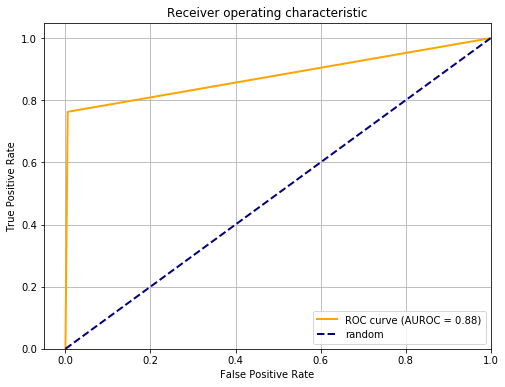

In [40]:
plot_roc_curve(roc_auc, fpr, tpr)

# Only For The Chosen Model

# Preparing the Model for Heroku 

#### Creating Baseline

In [26]:
pipeline = make_pipeline(ce.OneHotEncoder(handle_unknown='ignore'),
                         SimpleImputer(strategy='median'),
                       RandomForestClassifier(random_state=42),
                        )

In [27]:
pipeline.fit(X_train,y_train)

C:\Users\caixi\Anaconda3\envs\capstone_project\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['department_name',
                                     'interventionlocationname',
                                     'interventionreasoncode',
                                     'searchauthorizationcode',
                                     'statutereason'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='ignore', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=T...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decreas

#### Preparing new observations

In [ ]:
## They will enter as a Json String 
# new_obs_dict = json.loads(new_obs_str)

In [ ]:
# obs = pd.DataFrame([new_obs_dict],X_train.columns.tolist())

In [ ]:
# obs = obs.astype(X_train.dtypes)

#### Implement the Pre-Processing on New Observations

#### Serializing the Columns in the correct order

In [28]:
with open('columns.json', 'w') as fh:
    json.dump(X_train.columns.tolist(),fh)

In [30]:
with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train.dtypes,fh)

#### Serializing the fitted model

In [31]:
joblib.dump(pipeline,'pipeline.pickle')

['pipeline.pickle']

#### Deserialize the Model

- This step is to be applied in the in the server I believe

In [ ]:
# Deserializing Columns
with open('columns.json', 'r') as fh:
    columns = json.load(fh)

In [ ]:
# Un-pickle Dtypes
with open('dtypes.pickle', 'rb') as fh:
    pickle.load(fh)

In [ ]:
# Deserializing pipeline
model_fitted = joblib.load('pipeline.pickle')